# INTRODUCTION

Before choosing a location, entrepreneurs need to know their future businesses, understanding their needs, and identifying who your customers are and how you can best meet their needs. However, if your new business does not manufacture products, wholesale, or sell strictly over the Internet, then finding the right location to set up your business, from your customers’ point of view, can be critical to your success.

The present study will analyze commercial patterns in each particular borough in Toronto, focusing on to scope out the competition. 

__Hypothetical situation:__ A data scientist is hired to identify a location (borough) with a higher probability of success to start a new business in Toronto.

__Case of study:__ Restaurant.




## Importing needed packages

During each modeling steps of this project, we will import libraries, as well as packages, as needed.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.html import read_html
import pgeocode
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Estructure a json file into a pandas dataframe
#from pandas.io.json import json_normalize
import requests # library to handle requests


# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:

# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.22.1


# DATA

The data used here will be a combination of: 
- Postal codes, borough, and neighborhood names obtained by web scrapping.
- Geographical coordinates of each postal code obtained using the Pgeocode Python library.
- Venues data of each borough obtained using the Foursquare API.


Each source of data is properly commented on throughout this project as well as their respective URLs indicated.


# METHODOLOGY


The methodology steps adopted in this project are summarized below:

- Web scrape to obtain the postal codes, borough, and neighborhood names.
- Get the geographical coordinates of each postal code using the Pgeocode Python library.
- Join all the previous information obtained so far in a pandas dataframe.
- Use the Foursquare API to explore the 100 most common venues for each particular borough.
- Analyze the most common venues by borough considering the mean of the frequency as our metric and, assing the results to a dataframe.
- Apply k-means clustering to group together boroughs with similar venues' data and discover underlying patterns.
- Interactively visualize spatial data that has been manipulated so far, using the Folium library.
- Discuss the insights observed in each cluster.




# <span style="color:#164597">ANALYSIS OF TORONTO</span> 

Now, let us start our analysis considering the city of Toronto.

## Web scraping, data wrangling and cleaning

Now, we are going to web scrape the following [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) page, to obtain the postal codes, borough, and neighborhood names of Toronto, converting it to a pandas data frame. This data will be used later with the Foursquare API.

In [3]:
# extract tables from wikipedia

webpage = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'


# read_html returns a list of Dataframes. Therefore, you need to specify [0] to select the first item of the list.
# "class":"wikitable" - Just right click over the element of interest of the webpage selecting the inspect option 
# .                     then looking at the name of the class.
df = read_html(webpage,  attrs={"class":"wikitable"})[0]



print ('The extracted table has {rows} rows and {col} columns.'.format(rows=df.shape[0],col=df.shape[1]))

The extracted table has 180 rows and 3 columns.


In [4]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   180 non-null    object
 1   Borough       180 non-null    object
 2   Neighborhood  180 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB


We can observe that we have no missing values. Now, we will proceed to check the unique values found in the columns 'Borough' and, 'Neighbourhood'.

In [6]:
df['Borough'].value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [7]:
#df['Neighborhood'].unique()

In [8]:
df['Neighborhood'].value_counts()

Not assigned                                                                                                                              77
Downsview                                                                                                                                  4
Don Mills                                                                                                                                  2
Parkdale, Roncesvalles                                                                                                                     1
Harbourfront East, Union Station, Toronto Islands                                                                                          1
East Toronto, Broadview North (Old East York)                                                                                              1
Leaside                                                                                                                                    1
South Steeles

As indicated above, at the column Borough 77 strings “Not assigned
” were encountered, while at the column Neighbourhood 77. However, we do not know if these strings appeared simultaneously in both columns. Therefore, we will proceed to investigate before starting to clean the data. 

In [9]:
a = df.loc[(df['Neighborhood'] == 'Not assigned') & (df['Borough'] == 'Not assigned')]
a

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
7,M8A,Not assigned,Not assigned
10,M2B,Not assigned,Not assigned
15,M7B,Not assigned,Not assigned
16,M8B,Not assigned,Not assigned
19,M2C,Not assigned,Not assigned
24,M7C,Not assigned,Not assigned
25,M8C,Not assigned,Not assigned
28,M2E,Not assigned,Not assigned


In [10]:
len(a)

77

It turns out that all the cells at the Borough columns that are "Not assigned", 77, correspond to a "Not assigned" cells at the Neighbourhood column. Therefore, we will proceed by dropping the rows that have "Not assigned" cells in both columns.


In [11]:
# Dropping the rows that have "Not assigned" cells in both columns Borough and Neighbourhood.

df.drop(df[(df['Neighborhood'] == 'Not assigned') & (df['Borough'] == 'Not assigned')].index,inplace=True)

# Dropping the current index of the DataFrame and replaces it with an index of increasing integers.

df.reset_index(drop=True, inplace=True)

df.shape

(103, 3)

As expected, 77 rows were dropped in the new dataframe.

In [12]:
# Verify the existence of duplicated postal code rows.
df.groupby('Postal Code')['Neighborhood'].count()

Postal Code
M1B    1
M1C    1
M1E    1
M1G    1
M1H    1
M1J    1
M1K    1
M1L    1
M1M    1
M1N    1
M1P    1
M1R    1
M1S    1
M1T    1
M1V    1
M1W    1
M1X    1
M2H    1
M2J    1
M2K    1
M2L    1
M2M    1
M2N    1
M2P    1
M2R    1
M3A    1
M3B    1
M3C    1
M3H    1
M3J    1
M3K    1
M3L    1
M3M    1
M3N    1
M4A    1
M4B    1
M4C    1
M4E    1
M4G    1
M4H    1
M4J    1
M4K    1
M4L    1
M4M    1
M4N    1
M4P    1
M4R    1
M4S    1
M4T    1
M4V    1
M4W    1
M4X    1
M4Y    1
M5A    1
M5B    1
M5C    1
M5E    1
M5G    1
M5H    1
M5J    1
M5K    1
M5L    1
M5M    1
M5N    1
M5P    1
M5R    1
M5S    1
M5T    1
M5V    1
M5W    1
M5X    1
M6A    1
M6B    1
M6C    1
M6E    1
M6G    1
M6H    1
M6J    1
M6K    1
M6L    1
M6M    1
M6N    1
M6P    1
M6R    1
M6S    1
M7A    1
M7R    1
M7Y    1
M8V    1
M8W    1
M8X    1
M8Y    1
M8Z    1
M9A    1
M9B    1
M9C    1
M9L    1
M9M    1
M9N    1
M9P    1
M9R    1
M9V    1
M9W    1
Name: Neighborhood, dtype: int64

In [13]:
df

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


## PART II - Geographical coordinates


Now, we will proceed by getting the geographical coordinates of each postal code. For the present project, we are interested in a reliable free package. Since the [Google Maps Geocoding API](https://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike)  started charging we have excluded this option. We have tested the [Geocoder Python package](https://geocoder.readthedocs.io/) with the following piece of code:

__lat_lng_coords = None__  

__while(lat_lng_coords is None):__  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))__  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;__lat_lng_coords = g.latlng__  

__latitude = lat_lng_coords[0]__  
__longitude = lat_lng_coords[1]__  

However, this Package has a problem in which we have to be persistent (while loop), in a sense that we can make a call and the result would be None, and then make a call again and get the coordinates. Unfortunately, even with the while loop, the Geocoder Python package was very unreliable. Finally, a very good alternative used here was the [Pgeocode Python library](https://pgeocode.readthedocs.io/en/latest/index.html) designed for high-performance off-line querying of GPS coordinates, region name and municipality name from postal codes. This package has the advantage of returning a pandas.DataFrame, as a result of a geo-location query, the content of its columns are described below:

- country code: iso country code, 2 characters.
- postal code : postal code.
- place name : place name (e.g. town, city, etc).
- state_name : 1. order subdivision (state).
- state_code : 1. order subdivision (state).
- county_name : 2. order subdivision (county/province).
- county_code : 2. order subdivision (county/province).
- community_name : 3. order subdivision (community).
- community_code : 3. order subdivision (community).
- latitude : estimated latitude.
- longitude : estimated longitude.
- accuracy : accuracy of lat/lng from 1=estimated to 6=centroid.

In [14]:
# Get locations information from postal codes

nomi = pgeocode.Nominatim('CA')
nomi.query_location('Toronto,Ontario')

List_pcodes = list(df['Postal Code'])
df2 = nomi.query_postal_code(List_pcodes)
df2

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN
5,M9A,CA,Etobicoke (Islington Avenue),Ontario,ON,Etobicoke,NaN,NaN,NaN,43.6662,-79.5282,6.0
6,M1B,CA,Scarborough (Malvern / Rouge River),Ontario,ON,Scarborough,NaN,NaN,NaN,43.8113,-79.1930,6.0
7,M3B,CA,Don Mills North,Ontario,ON,Don Mills,NaN,NaN,NaN,43.7450,-79.3590,4.0
8,M4B,CA,East York (Parkview Hill / Woodbine Gardens),Ontario,ON,East York,NaN,NaN,NaN,43.7063,-79.3094,6.0
9,M5B,CA,Downtown Toronto (Ryerson),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6572,-79.3783,6.0


In [15]:
# Rename the postal codes collumn according to df

df2.rename(columns={'postal_code': 'Postal Code'},inplace=True)
df2.head()

,Postal Code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN


In [16]:
df2.shape

(103, 12)

Now, we will proceed connecting the rows of df and df2 based on the postal codes.

In [17]:
# Join df and df2 using the Postal Code column as the key
df3=pd.merge(df,df2,on='Postal Code')
df3.head()

,Postal Code,Borough,Neighborhood,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,North York,Parkwoods,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,North York,Victoria Village,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",CA,Downtown Toronto (Regent Park / Port of Toronto),Ontario,ON,Toronto,8133394.0,NaN,NaN,43.6555,-79.3626,6.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",CA,Queen's Park Ontario Provincial Government,Ontario,ON,NaN,NaN,NaN,NaN,43.6641,-79.3889,NaN


Inconsistencies can be obeserved between collumns "Neighborhood" and "place_name". For simplicity, we will be using collumn "Neighborhood" data.  A more accurate investigation is out of the scope of the present work which is to illustrate the application of web scrapping, Foursquare API and, k-means clustering to explore neighborhoods in Toronto.

In [18]:
df3.shape

(103, 14)

## USAR O PARAMETRO ABAIXO NA ANÁLISE!!!!

In [19]:
#USAR ISSO AQUI
df3['place_name'].value_counts()

Scarborough (Woburn)                                                                                                                                         1
North York (Glencairn)                                                                                                                                       1
Scarborough (Milliken / Agincourt North / Steeles East / L'Amoreaux East)                                                                                    1
Downtown Toronto (Rosedale)                                                                                                                                  1
Downsview East (CFB Toronto)                                                                                                                                 1
West Toronto (High Park / The Junction South)                                                                                                                1
York (Cedarvale)                              

In [20]:
# Simplifying the dataframe

df3.drop(['country code','place_name','state_name','state_code','county_name','county_code','community_name'\
          ,'community_code','accuracy'], axis=1, inplace= True)


df3.head()

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


Now, let us check if there are any missing values.

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Postal Code   103 non-null    object 
 1   Borough       103 non-null    object 
 2   Neighborhood  103 non-null    object 
 3   latitude      102 non-null    float64
 4   longitude     102 non-null    float64
dtypes: float64(2), object(3)
memory usage: 4.8+ KB


We can observe that we have in our dataframe one missing value for latitude and another for longitude which is probably in the same row. Therefore, let us verify this hypothesis.

In [22]:
df3.loc[(df3.latitude.isnull()) & (df3.longitude.isnull())]

,Postal Code,Borough,Neighborhood,latitude,longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN


In [23]:
# Dropping missing values
df3.dropna(inplace=True)
df3.reset_index(drop=True, inplace=True)

df3.shape

(102, 5)

In [24]:
df3['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Name: Borough, dtype: int64

In [25]:
df3['Neighborhood'].value_counts()

Downsview                                                                                                                                 4
Don Mills                                                                                                                                 2
The Beaches                                                                                                                               1
Del Ray, Mount Dennis, Keelsdale and Silverthorn                                                                                          1
Parkview Hill, Woodbine Gardens                                                                                                           1
Richmond, Adelaide, King                                                                                                                  1
North Park, Maple Leaf Park, Upwood Park                                                                                                  1
Dufferin, Dovercourt

## PART III - Geospatial analysis in Toronto

FALAR SOBRE O Q FAREI (...)

At this point, we will use the highly intuitive folium library, which allows us to interactively (leaflet map) visualize spatial data that has been manipulated so far. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map. The library has several built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. Furthermore, it supports both Image, Video, GeoJSON, and TopoJSON overlays (check this documentation [link](https://python-visualization.github.io/folium) for further details).


Let us start our analysis by creating a map of Toronto using latitude and longitude values from our dataframe as markers.

In [26]:
lat_downtown_Toronto = df3.loc[2,'latitude']
lng_downtown_Toronto = df3.loc[2,'longitude']

# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[lat_downtown_Toronto, lng_downtown_Toronto], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3.latitude, df3.longitude, df3.Borough, df3.Neighborhood):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Foursquare credentials

To access Foursquare data, it is necessary specific credentials. Therefore, first, we need to create a Foursquare account, then create a developer account at this [website](https://developer.foursquare.com), after that we will fill a form with the app description, then you can create an app. After all this process, you will have access to the specific credentials and can start making calls to the API and retrieving data.


We will not show the Foursquare credentials for this application here. Because they are unique for each program, and this information would be a security breach, in which anyone would be able to manipulate and probably abuse this program. Therefore, this information will be imported from a .py file, at the same directory as this Jupiter notebook, in the following format:

__CLIENT_ID = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"__  
__CLIENT_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"__  
__VERSION = '"XXXXXXXXXXXX"__


In [27]:
# Importing user credentials

import Credentials_to_access_Foursquare


client_ID = Credentials_to_access_Foursquare.CLIENT_ID
client_secret = Credentials_to_access_Foursquare.CLIENT_SECRET
version = Credentials_to_access_Foursquare.VERSION

## Exploring Downtown Toronto

Before a deep dive into our analysis, let us start by exploring the borough of Downtown Toronto of our dataframe. Our purpose here is getting the top 100 venues that are in Downtown Toronto within a radius of 500 meters.



In [28]:
# Limit of the number of venues returned by Foursquare API
LIMIT = 100

# Define radius
radius = 500 

# Create the Foursquare GET request URL.
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(client_ID, client_secret, version, lat_downtown_Toronto, lng_downtown_Toronto, radius, LIMIT)

# Send the GET request and examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eebfde56d8c5600282ad0c4'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 43.660000004500006,
    'lng': -79.3563918719477},
   'sw': {'lat': 43.6509999955, 'lng': -79.36880812805231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'di

Now, we will extract the useful information of the json file contained in the items key, and structure it into a pandas dataframe.

In [29]:
# Extract the useful information of the json file contained in the items key

venues = results['response']['groups'][0]['items']

# Normalize semi-structured JSON data into a flat table.
nearby_venues = pd.json_normalize(venues)

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]



nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Roselle Desserts,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",43.653447,-79.362017
1,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.653559,-79.361809
2,Figs Breakfast & Lunch,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",43.655675,-79.364503
3,The Yoga Lounge,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",43.655515,-79.364955
4,Body Blitz Spa East,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...",43.654735,-79.359874


Each item of the column venue.categories is a dictionary to extract this information we will use the following function:

In [30]:
# Function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [31]:
# Clean columns names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

nearby_venues.head()

24 venues were returned by Foursquare.


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
3,The Yoga Lounge,Yoga Studio,43.655515,-79.364955
4,Body Blitz Spa East,Spa,43.654735,-79.359874


## Explore Boroughs in Toronto

Now, we will create a function to extend the previous analysis to all boroughs of Toronto presented in our dataframe. It is worth mention that boroughs as administrative units are to be found in Ireland and the United Kingdom, more specifically in England and Northern Ireland. Boroughs also exist in the Canadian province of Quebec and formerly in Ontario, in some states of the United States, in Israel, formerly in New Zealand and only one left in Australia (check for further details this [link](https://en.wikipedia.org/wiki/Borough#:~:text=Boroughs%20as%20administrative%20units%20are,in%20England%20and%20Northern%20Ireland)).

In [32]:
###################################################################################################
### Purpose: It returns data in a dataframe format from several venues of a particular borough. ###
###################################################################################################

def getNearbyVenues(names, latitudes, longitudes, CLIENT_ID, CLIENT_SECRET, VERSION, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        '''
        - It iterates over each venue's information encountered for that particular borough.
        - Each item appended to the venues_list list for one iteration of the for loop has the 
        same borough name, lat and long, and different information for each venue.
        '''
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Create a pandas dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    # Set the columns labels
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
Toronto_venues = getNearbyVenues(names=df3['Borough'], latitudes=df3['latitude'],longitudes=df3['longitude'],
                                 CLIENT_ID=client_ID,CLIENT_SECRET=client_secret,VERSION=version)

North York
North York
Downtown Toronto
North York
Downtown Toronto
Etobicoke
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
West Toronto
Scarborou

In [34]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2162, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,North York,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North York,43.7545,-79.3300,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,North York,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York,43.7276,-79.3148,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [35]:
Toronto_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162 entries, 0 to 2161
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Borough            2162 non-null   object 
 1   Borough Latitude   2162 non-null   float64
 2   Borough Longitude  2162 non-null   float64
 3   Venue              2162 non-null   object 
 4   Venue Latitude     2162 non-null   float64
 5   Venue Longitude    2162 non-null   float64
 6   Venue Category     2162 non-null   object 
dtypes: float64(4), object(3)
memory usage: 118.4+ KB


No missing values encountered.

In [36]:
print('There are {} uniques venues categories.'.format(len(Toronto_venues['Venue Category'].unique())))

# Number of venues per borough

Toronto_venues.groupby('Borough').count()

There are 262 uniques venues categories.


,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Central Toronto,74,74,74,74,74,74
Downtown Toronto,1175,1175,1175,1175,1175,1175
East Toronto,86,86,86,86,86,86
East York,67,67,67,67,67,67
Etobicoke,99,99,99,99,99,99
North York,312,312,312,312,312,312
Scarborough,116,116,116,116,116,116
West Toronto,202,202,202,202,202,202
York,31,31,31,31,31,31


We can observe that the number of venues of Downtown Toronto is greater than the number of venues data retrieved for all the other boroughs together.

This time we are going to focus on the category of the venues, the idea here is verifying the most common venues by borough.

In [37]:
# Data Wrangling

# Convert categorical variable into dummy/indicator variables
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add the borough column back to dataframe
Toronto_onehot['Borough'] = Toronto_venues['Borough'] 

# Move borough column to the first column
columns_position = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[columns_position]

print(Toronto_onehot.shape)
Toronto_onehot.head()

(2162, 263)


,Borough,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [38]:
Toronto_onehot.tail()

,Borough,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
2157,Etobicoke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now, we will apply the split-apply-combine methodology by splitting the data of the previous dataframe, on its rows, into groups based on the boroughs. After that, we will calculate the mean of the frequency of the occurrence of each venue category.

In [39]:
# The mean of the frequency of occurrence of each category

Toronto_grouped = Toronto_onehot.groupby('Borough').mean().reset_index()

print(Toronto_grouped.shape)
Toronto_grouped

(9, 263)


,Borough,ATM,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.000000,0.00000,0.000000,0.000000,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Now, we will proceed with printing the top five venues by borough considering the mean of the frequency as our metric.

In [40]:
##############################################
##          Top venues by borough           ##
##############################################


num_top_venues = 5

for borough in Toronto_grouped['Borough']:    
    print("-----"+borough+"-----")
    
    # Assign to a new dataframe the information of the current borough, transposing 
    # the dataframe and resetting the index.
    temp = Toronto_grouped[Toronto_grouped['Borough'] == borough].T.reset_index()
    
    # Set columns labels
    temp.columns = ['venue','freq']
    
    # Eliminate the borough name from the current dataframe
    temp = temp.iloc[1:]
    
    temp['freq'] = temp['freq'].astype(float)
    
    # Round the frequency to two decimal places
    temp = temp.round({'freq': 2})
    
    # Print the top venues in descending order.
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

-----Central Toronto-----
                venue  freq
0                Park  0.12
1         Coffee Shop  0.07
2                Café  0.05
3      Sandwich Place  0.05
4  Italian Restaurant  0.04


-----Downtown Toronto-----
                 venue  freq
0          Coffee Shop  0.09
1                 Café  0.06
2                Hotel  0.04
3           Restaurant  0.04
4  Japanese Restaurant  0.03


-----East Toronto-----
                venue  freq
0    Greek Restaurant  0.09
1         Coffee Shop  0.06
2          Restaurant  0.06
3  Italian Restaurant  0.05
4                 Pub  0.05


-----East York-----
               venue  freq
0               Bank  0.07
1  Indian Restaurant  0.06
2        Coffee Shop  0.04
3     Sandwich Place  0.04
4         Restaurant  0.04


-----Etobicoke-----
            venue  freq
0     Pizza Place  0.08
1  Sandwich Place  0.06
2     Coffee Shop  0.06
3        Pharmacy  0.05
4            Bank  0.04


-----North York-----
            venue  freq
0  Clothing S

Now, that we have already illustrated above the five most common venues per borough, let us create a dataframe for later processing. It will return the most common venues per borough considering the mean of the frequency as our metric.

In [41]:
##################################################################################################################
### Purpose: It returns the most common venues by borough considering the mean of the frequency as our metric. ###
##################################################################################################################


def return_most_common_venues(row, num_top_venues):
    # Eliminate the borough name, considering just the frequencies with the venue's names as its indexes.
    row_categories = row.iloc[1:]
    
    # Sort the frequencies in descending order.
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # It returns the indexes (category names), not the frequencies, sorted.
    return row_categories_sorted.index.values[0:num_top_venues] 

Before we proceed, let us take a look at one row of the Toronto_grouped dataframe, representing the mean of the frequencies by venue category of Downtown Toronto.

In [42]:
Toronto_grouped.iloc[1, :]

Borough                                     Downtown Toronto
ATM                                                        0
Accessories Store                                          0
Afghan Restaurant                                0.000851064
Airport                                                    0
American Restaurant                                0.0161702
Art Gallery                                        0.0102128
Art Museum                                       0.000851064
Arts & Crafts Store                               0.00255319
Asian Restaurant                                   0.0102128
Athletics & Sports                               0.000851064
Auto Dealership                                            0
Auto Garage                                                0
BBQ Joint                                         0.00170213
Baby Store                                       0.000851064
Badminton Court                                            0
Bagel Shop              


The indexes represent the venue's categories related to their specific mean of the frequency. This information will be very helpful in the next algorithm.

In [43]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# Create columns labels according to the number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)

# Assign borough names information as well as their integer indexes.
boroughs_venues_sorted['Borough'] = Toronto_grouped['Borough']

# Assign the most common venues names sorted by the mean of their frequencies.
for ind in np.arange(Toronto_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Central Toronto,Park,Coffee Shop,Café,Sandwich Place,Italian Restaurant
1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
2,East Toronto,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
3,East York,Bank,Indian Restaurant,Restaurant,Pizza Place,Sandwich Place
4,Etobicoke,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
5,North York,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
6,Scarborough,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
7,West Toronto,Café,Coffee Shop,Bar,Restaurant,Bakery
8,York,Park,Brewery,Coffee Shop,Home Service,Hockey Arena


## Clustering the boroughs in Toronto

We are interested in grouping together boroughs with similar venues' data and discover underlying patterns. Therefore, we will proceed to cluster the boroughs in Toronto using an unsupervised machine learning algorithm. The one we will be using is called k-means, where its purpose is to minimize the distance of data points from the centroid of its clusters and maximize the distance from other cluster's centroids. The k-means basic steps are summarized below:

1. Set the number of clusters  K.
- Randomly initialize the centroids coordinates of each cluster.
- Calculate the distance of each data point from the centroid points. Depending on the nature of the data, different metrics for the distance may be used to place items into clusters. 
- Set the distance matrix, which is a matrix where each row represents the distance of a data point from each centroid.
- Use the distance matrix to find the nearest centroid to each data point, then assign each data point to the corresponding cluster.
- Compute the error, which is the sum of the squared distance between data points and all centroids.
- Update each centroid as the mean of all data points contained in its clusters.
- Repeat the process from step 3 until the centroids have stabilized, i.e., no significant change in their values is encountered.

For further details, check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and these articles [analyticsvidhya](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/), [towardsdatascience1](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) and,  [towardsdatascience2](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1).

It is worth noting that, as it is a heuristic algorithm, there is no guarantee that it will converge to the global optimum, and the result may depend on the initial clusters. In other words, this algorithm is guaranteed to converge to a result, but the result may be a local optimum, not necessarily the best possible outcome.

To overcome this issue, it is common to run the whole process multiple times with different starting conditions. The application of randomized starting centroids may give a better outcome. Besides, the algorithm is usually very fast, being not a problem running it multiple times. 


Before we proceed with applying the k-means algorithm, we have to choose the number of clusters. For this purpose, we apply the “elbow” method, using the [KElbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) from the [Yellowbrick library](https://www.scikit-yb.org/en/latest/), to select the optimal number of clusters by fitting the model with a range of values for k.


We will apply three different scoring parameter metric, with the main features summarized below:

- Distortion (default): It computes the sum of squared distances between each instance and its closest centroid. The desirable choice would be the lowest inertia. However, as pointed out by [Jyoti Yadav](https://medium.com/@jyotiyadav99111/selecting-optimal-number-of-clusters-in-kmeans-algorithm-silhouette-score-c0d9ebb11308) this approach has a limitation, as the number of clusters increases, the closest will be the clusters from the centroids and lower will be the inertia.

- Silhouette: The silhouette score calculates the mean Silhouette Coefficient of all samples, defined as:  
\begin{equation}
		\text{SC} =\frac{(p-q)}{\max(p,q)}
\end{equation}
where p is the mean distance to the points in the nearest cluster and q is the mean intra-cluster distance to all the points. The silhouette score raging from -1 to 1, with a brief description given below:
    - 1  − It indicates that the sample is far away from its neighboring cluster.
    - 0 - It indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.
    - -1 - It indicates that the samples have been assigned to the wrong clusters.
    See for further details this [article] (https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_analysis_of_silhouette_score.htm)


- Calinski-harabasz: The Calinski Harabasz score or variance ratio is the ratio between within-cluster dispersion and between-cluster dispersion. [Milligan et al.](https://doi.org/10.1007/BF02294245) compared 30 different approaches estimating the number of clusters in a dataset and found that the best performing method is given by [Calinski and Harabasz](https://www.tandfonline.com/doi/abs/10.1080/03610927408827101), with its score defined as: 
\begin{equation}
CH(k) = \frac{B(k)/(k-1)}{W(k)(n-k)}
\end{equation}
where B(k) is the inter-cluster variance (i.e. the sum of squared distances for the k clusters), and W (k) is the intracluster variance. Maximising CH(k) against different values of k gives the estimated number of clusters [(Kingrani and Dell Zhang)](http://dx.doi.org/10.5430/air.v7n1p15). 







/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


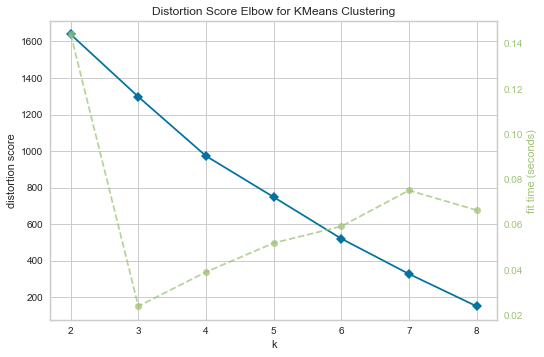

In [44]:
#############################################
###             ELBOW METHOD              ###
#############################################

Toronto_grouped_clustering_koptm = Toronto_grouped.drop('Borough', 1)

# Standardizing the data
data_scaled = StandardScaler().fit_transform(Toronto_grouped_clustering_koptm)

# Instantiate a scikit-learn K-Means model
modelK = KMeans(random_state=0)


#########################################
###        Distortion metric          ###
#########################################

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(modelK, k=(2,9))#,metric='calinski_harabasz')#, metric='silhouette')#, timings=False)

# Fit the data and visualize
visualizer.fit(data_scaled)    
visualizer.poof()

/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


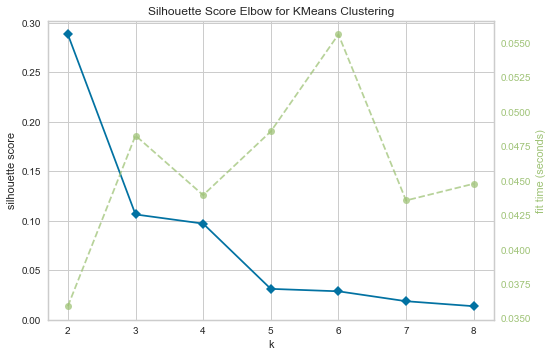

In [45]:
#########################################
###        Silhouette metric          ###
#########################################

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(modelK, k=(2,9), metric='silhouette')#,metric='calinski_harabasz')#, metric='silhouette')#, timings=False)

# Fit the data and visualize
visualizer.fit(data_scaled)    
visualizer.poof()

/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Applications/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


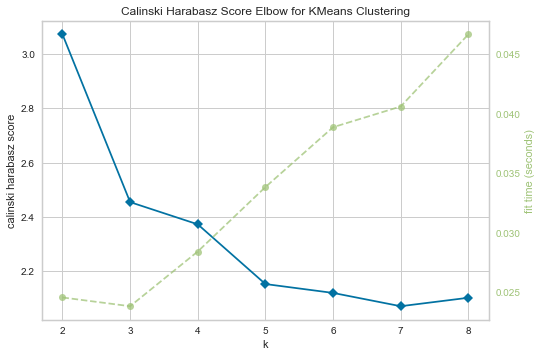

In [46]:
#########################################
###   Calinski - Harabasz metric      ###
#########################################

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(modelK, k=(2,9),metric='calinski_harabasz')#, metric='silhouette')#, timings=False)

# Fit the data and visualize
visualizer.fit(data_scaled)    
visualizer.poof()

We could not estimate an optimal k parameter from the inconclusive results obtained by the Elbow method, for the three different metrics used. A further investigation to choose a more suitable method is out of the scope of the present project, which is to illustrate the application of web scrapping, Foursquare API and, k-means clustering to explore neighborhoods in Toronto. However, to continuing our analysis, we will chose k based on the amount of time to train the clustering model. Therefore, four clusters will be chosen, since it corresponds to the lowest value of the amount of time to train the clustering model considering the distortion metric and, it also corresponds to reasonable low values considering the silhouette and Calinski- Harabasz metrics. A more accurate investigation, with an advanced methodology to estimate the optimal number of clusters, is out of the scope of the present work. However, to the ones interested in this topic, I strongly recommend the article published by [Boris Mirkin](https://onlinelibrary.wiley.com/doi/abs/10.1002/widm.15). 




In [47]:
#Toronto_grouped_clustering = Toronto_grouped.drop('Borough', 1)

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_scaled)#Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 0, 0, 4, 0, 3, 0], dtype=int32)

In [48]:
# Insert a column with the cluster labels

boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

'''
Assigning the information from the df3 dataframe, which has information on postal code, boroughs, 
neighborhoods, latitudes and, longitudes in Toronto.
'''
Toronto_merged = df3



In [49]:
Toronto_merged

,Postal Code,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6662,-79.5282
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
7,M3B,North York,Don Mills,43.7450,-79.3590
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


In [50]:
boroughs_venues_sorted

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Central Toronto,Park,Coffee Shop,Café,Sandwich Place,Italian Restaurant
1,1,Downtown Toronto,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
2,2,East Toronto,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
3,0,East York,Bank,Indian Restaurant,Restaurant,Pizza Place,Sandwich Place
4,0,Etobicoke,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
5,4,North York,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
6,0,Scarborough,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
7,3,West Toronto,Café,Coffee Shop,Bar,Restaurant,Bakery
8,0,York,Park,Brewery,Coffee Shop,Home Service,Hockey Arena


According to the book [Python for Data Analysis](https://www.amazon.com.br/Python-Data-Analysis-Wrangling-IPython-ebook/dp/B075X4LT6K/ref=sr_1_2?gclid=CjwKCAiAlajvBRB_EiwA4vAqiAXXwy4WUAHHiL4Zs-EpMigSUxEBB5h8Y5jetb3UI01o2Skc3NFrThoCDLcQAvD_BwE&hvadid=326918364388&hvdev=c&hvlocphy=1001655&hvnetw=g&hvpos=1t3&hvqmt=b&hvrand=7109147701698772108&hvtargid=kwd-298947497743&keywords=python+for+data+analysis&qid=1575699773&sr=8-2), the dataframe's join method performs a left join on the join keys, exactly preserving the left dataframe's row index. Besides, it also supports joining the index of the passed dataframe on one of the columns of the calling dataframe. Therefore, we are passing converting the "Borough column" of the boroughs_venues_sorted dataframe as its indexes and then set on='Borough' (the calling dataframe). 

In [51]:
Toronto_merged = Toronto_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

Toronto_merged

,Postal Code,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
1,M4A,North York,Victoria Village,43.7276,-79.3148,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6662,-79.5282,0,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930,0,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
7,M3B,North York,Don Mills,43.7450,-79.3590,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094,0,Bank,Indian Restaurant,Restaurant,Pizza Place,Sandwich Place
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant


Now, let us proceed to visualize the resulting clusters.

In [52]:
# Create map
map_clusters = folium.Map(location=[lat_downtown_Toronto, lng_downtown_Toronto], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['latitude'], Toronto_merged['longitude'], Toronto_merged['Borough'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
# Verifying
Toronto_merged['Cluster Labels'].unique()

array([4, 1, 0, 2, 3], dtype=int32)

Now, let us visualize the information of the boroughs as well as the venue's categories of each cluster.

In [54]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 0                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Etobicoke,0,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
6,Scarborough,0,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
8,East York,0,Bank,Indian Restaurant,Restaurant,Pizza Place,Sandwich Place
11,Etobicoke,0,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
12,Scarborough,0,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
14,East York,0,Bank,Indian Restaurant,Restaurant,Pizza Place,Sandwich Place
16,York,0,Park,Brewery,Coffee Shop,Home Service,Hockey Arena
17,Etobicoke,0,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Bank
18,Scarborough,0,Pizza Place,Coffee Shop,Pharmacy,Discount Store,Intersection
21,York,0,Park,Brewery,Coffee Shop,Home Service,Hockey Arena


In [55]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 1                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
4,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
9,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
15,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
20,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
24,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
25,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
30,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
36,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant
42,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Hotel,Japanese Restaurant


In [56]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 2                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,East Toronto,2,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
41,East Toronto,2,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
47,East Toronto,2,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
54,East Toronto,2,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub
99,East Toronto,2,Greek Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Pub


In [57]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 3                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery
37,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery
43,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery
69,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery
75,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery
80,West Toronto,3,Café,Coffee Shop,Bar,Restaurant,Bakery


In [58]:
###################################################################################################################
###                                     CLUSTER LABEL EQUALS 4                                                  ###
###################################################################################################################
### PROCEDURE: Apply a boolean mask considering column "Borough" and all columns from column "Cluster Labels".  ###
###################################################################################################################


Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
1,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
3,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
7,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
10,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
13,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
27,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
28,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
33,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant
34,North York,4,Coffee Shop,Clothing Store,Park,Pizza Place,Restaurant






The insights observed, considering the five most common venues categories per cluster, are summarized below: 


- __Cluster 0__: The boroughs contained in this cluster have shown balanced venues categories, in which you can find restaurants, fast foods, coffee shops, pharmacies, banks, and home services pretty much almost everything that any person could need. Besides, entertainment (Hockey arena) can also be found.
- __Cluster 1__: It seems to be a business center, with a focus on coffee shops, cafés, having hotels and restaurants available for a possible need.
- __Cluster 2__: There is a focus on gastronomical variety here, you can find several types of restaurants. Besides, entertainment for adults (pubs) is also available.
- __Cluster 3__: It seems to be a wealthy residential location with a lot of places to hang out with friends (bar), to chill (coffee shops), and good gastronomical options (restaurants, cafés, and bakeries).
- __Cluster 4__: This cluster appears to be a typical middle-class residential location, with parks for recreation, clothing stores for a possible need, coffee shops to chill, and some gastronomical options (pizza place and restaurant).


## Conclusion

The present study aimed at the analysis of commercial patterns in each particular borough in Toronto, focusing on to scope out the competition, to find the optimal location to open a new restaurant. Based on the patterns encountered, we can conclude the following:

- Cluster 2 boroughs would represent the hardest competition due to the gastronomical variety.
- The higher investment would be needed at boroughs in Clusters 1 and 3, due to the high quality provided by competing restaurants. 
- Even though Cluster 3 boroughs represent a balanced environment, it can be seen a reasonable variety of restaurants and fast food. High creativity and quality advertising would be necessary to attract customers.

The most reasonable choice, based in our clustering analysis, would be boroughs at Cluster 4. They have not so many gastronomical options, summed with the middle class-like environment, would not require a very sophisticated restaurant and excessive investment in advertisements.